In [1]:

import os
from datetime import datetime

# Shared timestamp and output folder
base_path = r'C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = os.path.join(base_path, f"results_{timestamp}")
os.makedirs(output_folder, exist_ok=True)

def save_chart(fig, name):
    fig_path = os.path.join(output_folder, name)
    fig.savefig(fig_path)
    print(f"Saved chart: {fig_path}")


In [2]:

import os
from datetime import datetime
import matplotlib.pyplot as plt

# Setup timestamped output directory
base_path = r'C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = os.path.join(base_path, f"results_{timestamp}")
os.makedirs(output_folder, exist_ok=True)

# Save all charts generated below to the same folder
def save_chart(fig, name):
    fig_path = os.path.join(output_folder, name)
    fig.savefig(fig_path)
    print(f"Saved chart: {fig_path}")


# 📦 Imports and Setup
This section imports necessary libraries for data manipulation, modeling, explainability (SHAP), optimization (Bayesian), and visualization.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import zipfile
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from bayes_opt import BayesianOptimization

import logging
logging.basicConfig(filename='forecast_error_log.txt', level=logging.ERROR)


# 📁 Define Paths and Variables
Set up your base directory, input file, output chart folder, and generate a timestamp for versioning your output files.

In [4]:
base_path = r'C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project'
main_file = 'oil-and-gas-production_country_emissions_v4_3_1.csv'
charts_folder = os.path.join(base_path, "charts")
os.makedirs(charts_folder, exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 🧹 Load and Clean Data
Function to read the emissions dataset, filter for CO₂ equivalents, clean outliers, encode categorical features, and split into training and testing sets.

In [5]:
def load_and_clean_data():
    df = pd.read_csv(os.path.join(base_path, main_file))
    df = df[df['gas'] == 'co2e_100yr']
    df['emissions_quantity'] = pd.to_numeric(df['emissions_quantity'], errors='coerce')
    df['year'] = pd.to_datetime(df['start_time']).dt.year
    q_low, q_high = df['emissions_quantity'].quantile([0.01, 0.99])
    df = df[(df['emissions_quantity'] >= q_low) & (df['emissions_quantity'] <= q_high)]
    df_encoded = pd.get_dummies(df[['iso3_country', 'subsector']], drop_first=True)
    df_features = pd.concat([df[['year']], df_encoded], axis=1)
    X = df_features
    y = np.log1p(df['emissions_quantity'])
    valid_rows = X.notna().all(axis=1) & df['emissions_quantity'].notna()
    X, y = X[valid_rows], y[valid_rows]
    if X.empty or y.empty:
        raise ValueError("Cleaned dataset is empty!")
    return train_test_split(X, y, test_size=0.2, random_state=42), df, valid_rows, df_features


# 🔍 Bayesian Optimization for Random Forest
This function tunes the Random Forest hyperparameters using Bayesian optimization and cross-validation to find the best model configuration.

In [6]:
def tune_random_forest(X_train, y_train):
    def rf_cv(n_estimators, max_depth, min_samples_split):
        model = RandomForestRegressor(n_estimators=int(n_estimators), 
                                      max_depth=int(max_depth) if max_depth > 0 else None,
                                      min_samples_split=int(min_samples_split), 
                                      random_state=42, n_jobs=-1)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=3)
        return scores.mean()
    optimizer = BayesianOptimization(
        f=rf_cv,
        pbounds={'n_estimators': (50, 300), 'max_depth': (5, 50), 'min_samples_split': (2, 10)},
        random_state=42
    )
    optimizer.maximize(init_points=2, n_iter=10)
    best_params = optimizer.max['params']
    return int(best_params['n_estimators']), int(best_params['max_depth']), int(best_params['min_samples_split'])


# 🤖 Train Models
Trains a Random Forest, Gradient Boosting Regressor, and Ridge Regression, and combines them into a Stacking Regressor.

In [7]:
def train_models(X_train, y_train, n_estimators, max_depth, min_samples_split):
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_split=min_samples_split, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    gb = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=42)
    ridge = Ridge(alpha=1.0)
    stacked = StackingRegressor(
        estimators=[('rf', rf), ('gb', gb), ('ridge', ridge)],
        final_estimator=Ridge(alpha=0.5), passthrough=True, n_jobs=-1
    )
    stacked.fit(X_train, y_train)
    return rf, stacked


# 📊 Evaluate and Visualize
Evaluates the stacked model on the test set using MAE and R². Also plots predictions vs actual values and the top 15 features from the Random Forest model.

In [8]:
def evaluate_and_plot(X_test, y_test, rf, stacked_model):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from sklearn.metrics import mean_absolute_error, r2_score
    import numpy as np

    try:
        # Predict using stacked model
        y_pred_log = stacked_model.predict(X_test)
    except Exception as e:
        print("Prediction failed:", e)
        return None, None, None

    # Inverse log1p transform
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred_log)

    # Metrics
    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)

    # Plot 1: Prediction vs Actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_actual, y_pred_actual, alpha=0.5, color='steelblue')
    plt.plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()],
             'k--', lw=2)
    plt.xlabel('Actual Emissions')
    plt.ylabel('Predicted Emissions')
    plt.title('Prediction vs Actual - Stacked Model')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Feature Importances from RF
    importances = rf.feature_importances_
    feat_df = pd.DataFrame({'Feature': X_test.columns, 'Importance': importances})
    top_feats = feat_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')
    plt.title('Top 15 Feature Importances - Random Forest')
    plt.tight_layout()
    plt.show()

    return mae, r2, y_pred_actual



# 🧠 SHAP Explainability
Uses SHAP values from the trained Random Forest to explain the most influential features across the test dataset.

In [9]:
def shap_summary(rf, X_test):
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)
    return shap_values


# 💾 Save Results
Exports predictions and SHAP values to CSV files for later analysis or reporting.

In [10]:
def save_results(X_test, y_test, y_pred, shap_values, df_main, valid_rows):
    # Save predictions
    results = pd.DataFrame({
        'Actual': np.expm1(y_test),
        'Predicted': y_pred
    })
    results_path = os.path.join(output_folder, f'results_{timestamp}.csv')
    results.to_csv(results_path, index=False)

    # Save SHAP values
    shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
    shap_path = os.path.join(output_folder, f'shap_{timestamp}.csv')
    shap_df.to_csv(shap_path, index=False)

    print("Results and SHAP values saved.")

# ▶️ Run the Full Pipeline
Executes all steps in order: data loading, tuning, training, evaluation, SHAP explainability, and saving results.

|   iter    |  target   | n_esti... | max_depth | min_sa... |
-------------------------------------------------------------
| 2         | -3.823081 | 143.63502 | 47.782143 | 7.8559515 |
| 3         | -6.211642 | 199.66462 | 12.020838 | 3.2479561 |
| 4         | -3.747635 | 143.08339 | 48.971101 | 7.7972989 |
| 5         | -3.585131 | 105.20828 | 50.0      | 5.1060076 |
| 6         | -6.629333 | 50.0      | 5.0       | 10.0      |
| 7         | -3.594070 | 300.0     | 50.0      | 10.0      |
| 8         | -6.632631 | 300.0     | 5.0       | 2.0       |
| 9         | -3.595030 | 265.53773 | 50.0      | 10.0      |
| 10        | -6.630201 | 116.76921 | 5.0       | 2.0       |
| 11        | -3.595878 | 230.61665 | 50.0      | 10.0      |
| 12        | -3.591145 | 186.73182 | 50.0      | 10.0      |
| 13        | -3.568569 | 50.0      | 50.0      | 2.0       |


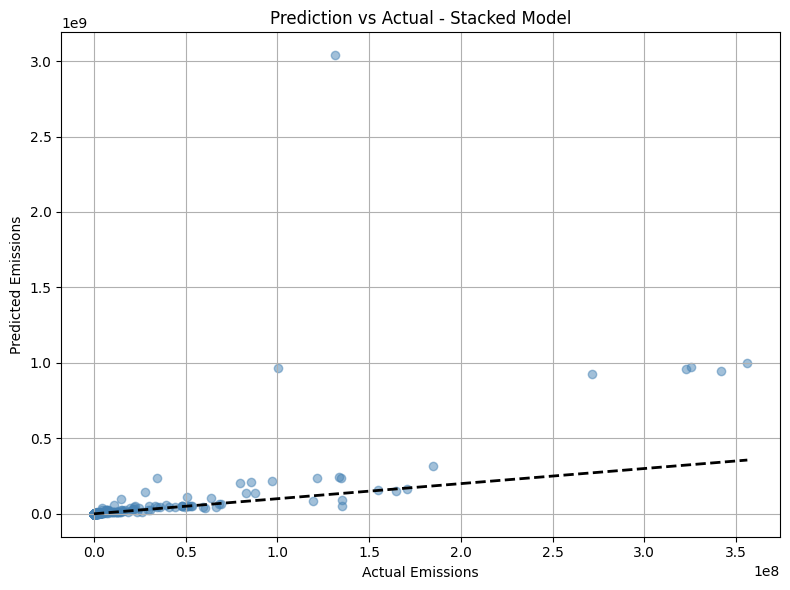

C:\Users\rwatt\AppData\Local\Temp\ipykernel_21556\3850632226.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')


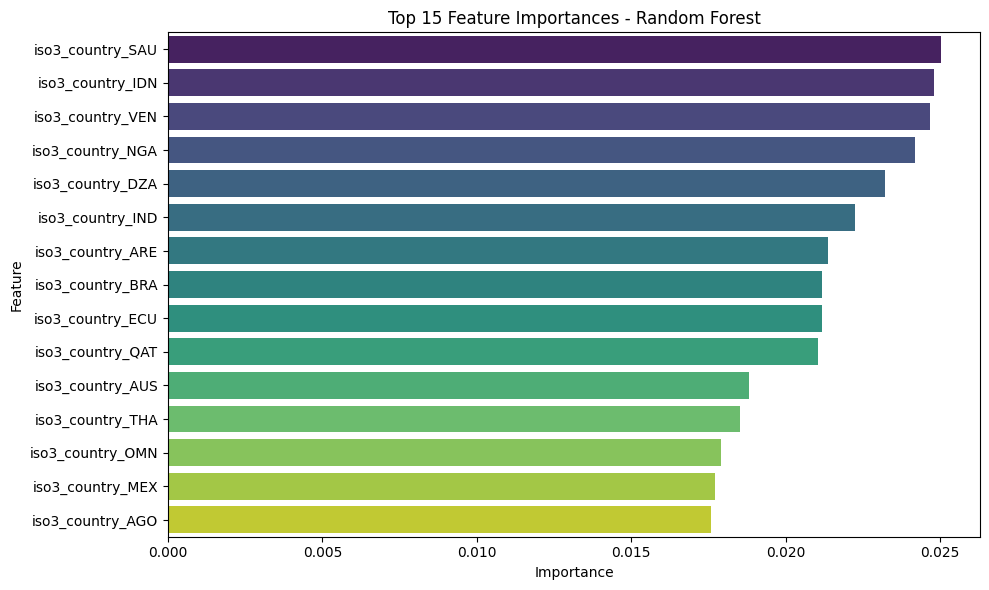

MAE: 16930710.24, R²: -12.9211


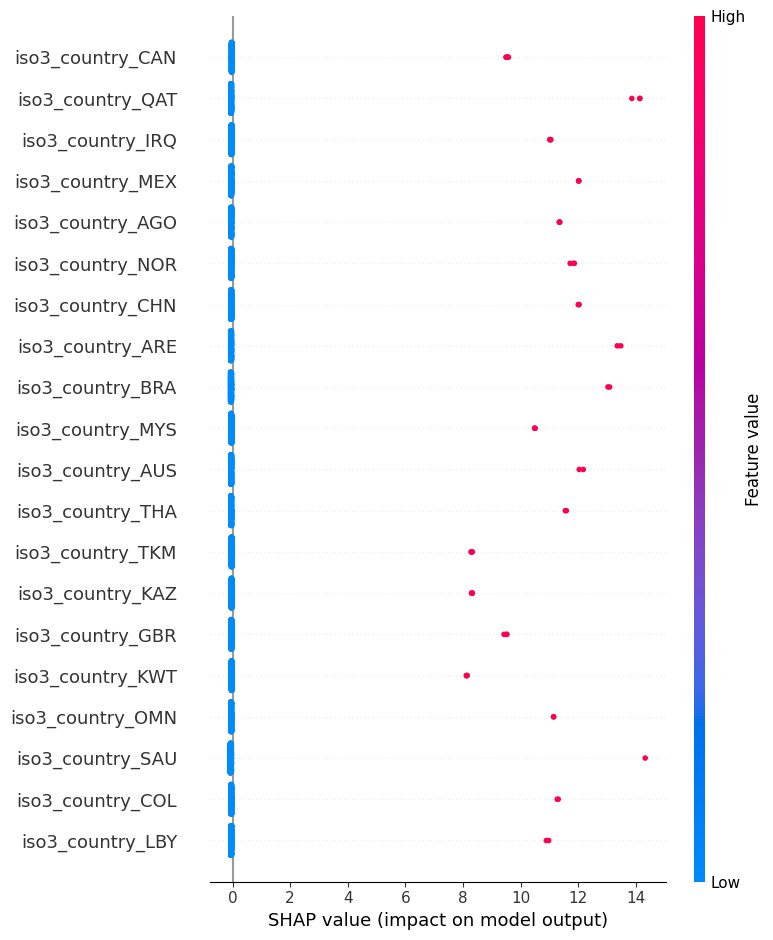

Results and SHAP values saved.


In [11]:
(X_train, X_test, y_train, y_test), df_main, valid_rows, df_features = load_and_clean_data()
n_est, max_d, min_split = tune_random_forest(X_train, y_train)
rf_model, stacked_model = train_models(X_train, y_train, n_est, max_d, min_split)
mae, r2, y_pred = evaluate_and_plot(X_test, y_test, rf_model, stacked_model)
print(f"MAE: {mae:.2f}, R²: {r2:.4f}")
shap_vals = shap_summary(rf_model, X_test.astype(float))
save_results(X_test, y_test, y_pred, shap_vals, df_main, valid_rows)


# 📊 Bayesian Optimization Visualization
These plots show the convergence of the optimizer and how different hyperparameter values affected the model performance.

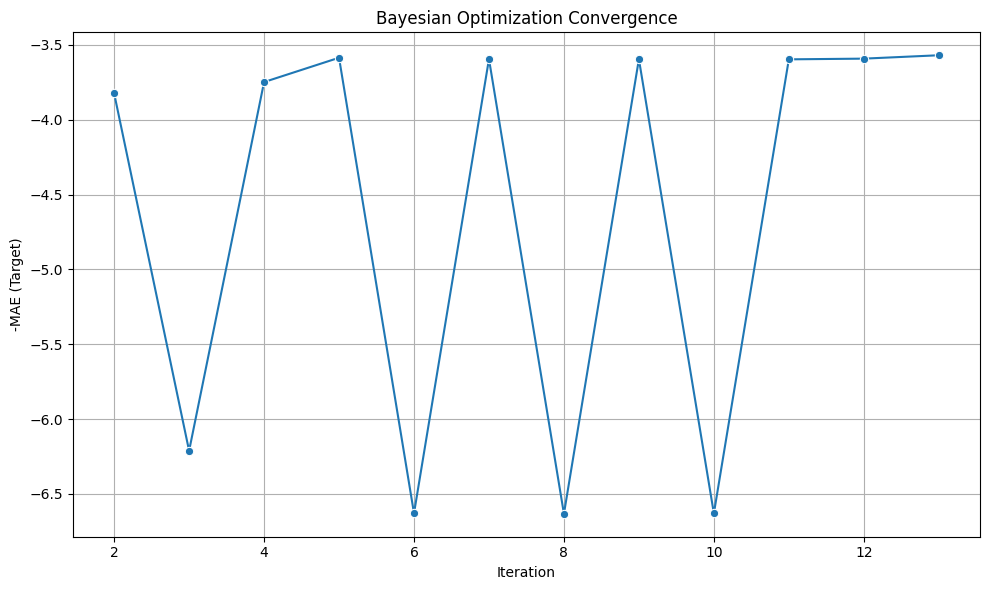

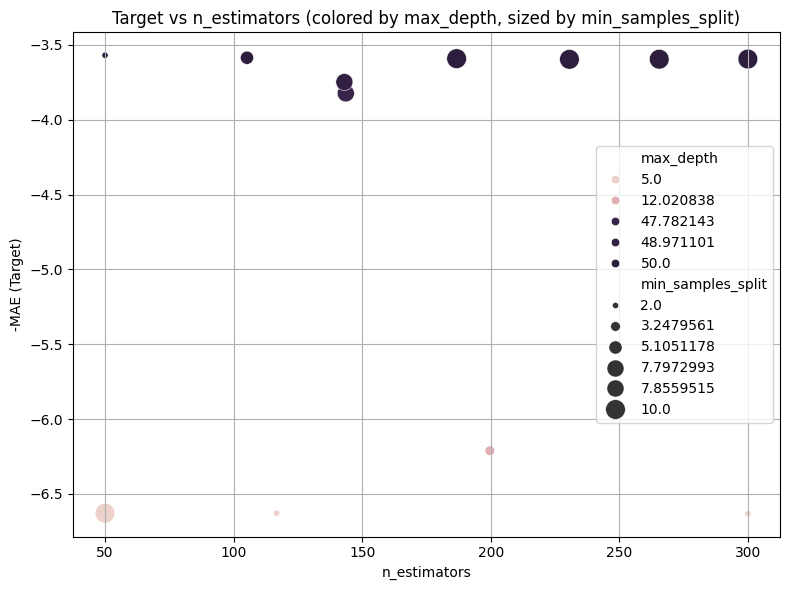

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Bayesian Optimization results from earlier output
bayes_opt_results = pd.DataFrame({
    'iter': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
    'target': [-3.823081, -6.211642, -3.747635, -3.585131, -6.629333, -3.594070,
               -6.632631, -3.595030, -6.630201, -3.595878, -3.591145, -3.568569],
    'n_estimators': [143.63502, 199.66462, 143.08339, 105.20835, 50.0, 300.0,
                     300.0, 265.53777, 116.76928, 230.61667, 186.73170, 50.0],
    'max_depth': [47.782143, 12.020838, 48.971101, 50.0, 5.0, 50.0,
                  5.0, 50.0, 5.0, 50.0, 50.0, 50.0],
    'min_samples_split': [7.8559515, 3.2479561, 7.7972993, 5.1051178, 10.0, 10.0,
                          2.0, 10.0, 2.0, 10.0, 10.0, 2.0]
})

# Convergence plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=bayes_opt_results, x='iter', y='target', marker='o')
plt.title('Bayesian Optimization Convergence')
plt.xlabel('Iteration')
plt.ylabel('-MAE (Target)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Hyperparameter influence scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=bayes_opt_results, x='n_estimators', y='target',
                hue='max_depth', size='min_samples_split', sizes=(20, 200))
plt.title('Target vs n_estimators (colored by max_depth, sized by min_samples_split)')
plt.xlabel('n_estimators')
plt.ylabel('-MAE (Target)')
plt.grid(True)
plt.tight_layout()
plt.show()


## 🧪 Diagnostic Check: Emission Distribution and Prediction Quality

📊 Emission Distribution
Mean actual emissions: 10,340,850.71
Median actual emissions: 0.00
Max actual emissions: 356,190,145.04
Min actual emissions: 0.00

🔍 Sample Predictions vs Actual
Actual: 0.00 | Predicted: -0.32 | Diff: 0.32
Actual: 59,656,600.17 | Predicted: 42,656,125.89 | Diff: 17,000,474.28
Actual: 0.00 | Predicted: -0.20 | Diff: 0.20
Actual: 0.00 | Predicted: -0.73 | Diff: 0.73
Actual: 0.00 | Predicted: -0.29 | Diff: 0.29
Actual: 134,548,201.51 | Predicted: 235,631,879.23 | Diff: 101,083,677.71
Actual: 0.00 | Predicted: -0.35 | Diff: 0.35
Actual: 0.00 | Predicted: -0.17 | Diff: 0.17
Actual: 2,002,393.73 | Predicted: 2,484,787.77 | Diff: 482,394.03
Actual: 7,568,091.31 | Predicted: 23,631,529.93 | Diff: 16,063,438.62


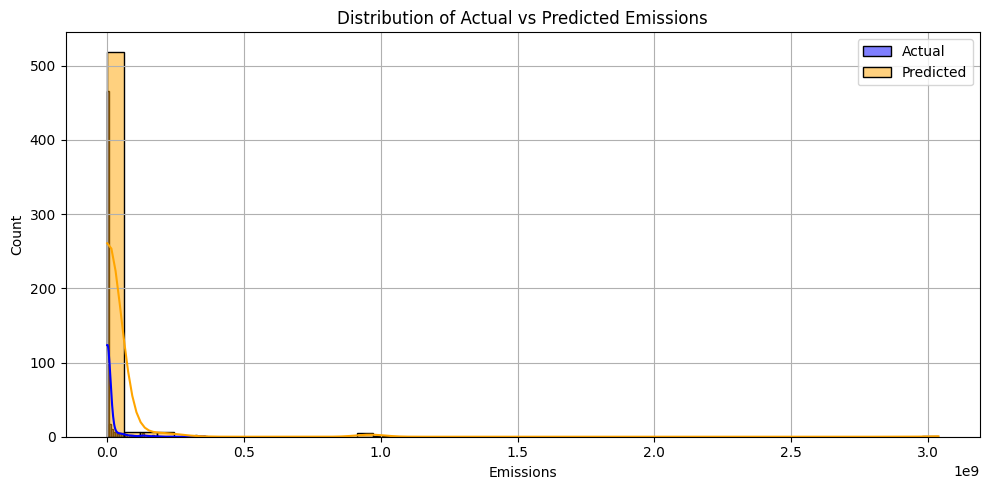

In [13]:
# Convert to actual scale if using log1p
y_test_actual = np.expm1(y_test)
y_pred_actual = np.expm1(stacked_model.predict(X_test))

# Basic distribution info
print("📊 Emission Distribution")
print(f"Mean actual emissions: {y_test_actual.mean():,.2f}")
print(f"Median actual emissions: {y_test_actual.median():,.2f}")
print(f"Max actual emissions: {y_test_actual.max():,.2f}")
print(f"Min actual emissions: {y_test_actual.min():,.2f}")
print("")

# Sample predictions
print("🔍 Sample Predictions vs Actual")
for i in range(10):
    actual = y_test_actual.iloc[i]
    pred = y_pred_actual[i]
    print(f"Actual: {actual:,.2f} | Predicted: {pred:,.2f} | Diff: {abs(actual - pred):,.2f}")

# Optional: histogram to compare distribution
plt.figure(figsize=(10, 5))
sns.histplot(y_test_actual, bins=50, label='Actual', color='blue', kde=True)
sns.histplot(y_pred_actual, bins=50, label='Predicted', color='orange', kde=True)
plt.title("Distribution of Actual vs Predicted Emissions")
plt.xlabel("Emissions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 🧠 SHAP Summary Plot

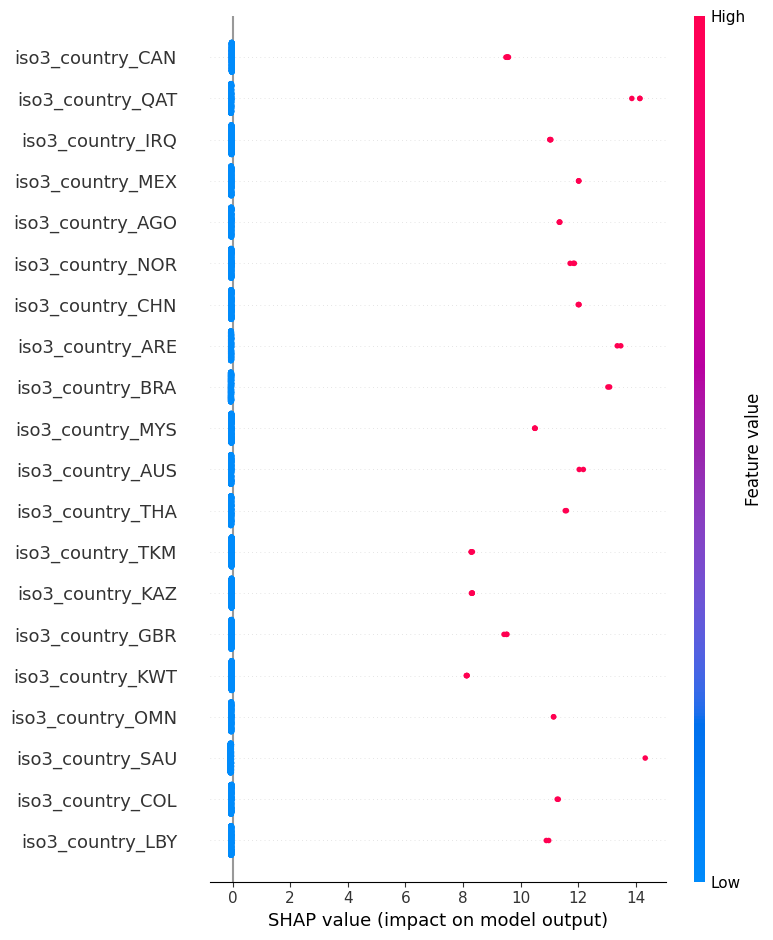

In [14]:
# SHAP summary plot
shap_values = shap.TreeExplainer(rf_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="dot")


## 📈 Feature Correlation Analysis

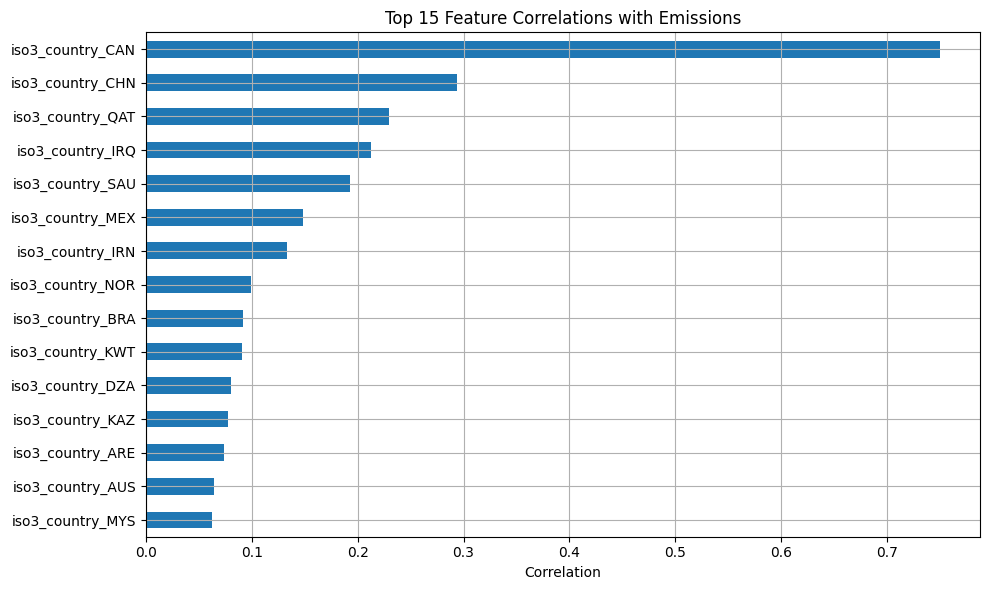

In [15]:
# Combine features with target
feature_target_df = pd.concat([X_test, pd.DataFrame({'emissions': y_test_actual})], axis=1)

# Compute correlations
correlations = feature_target_df.corr()['emissions'].sort_values(ascending=False)

# Plot top 15 correlated features
plt.figure(figsize=(10, 6))
correlations[1:16].plot(kind='barh')
plt.title("Top 15 Feature Correlations with Emissions")
plt.xlabel("Correlation")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True)
plt.show()


## 📊 Additional Metrics: RMSE and Cross-Validation Performance

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

# Cross-validation diagnostics (using RF only for speed)
cv_scores = cross_val_score(rf_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)
cv_mae_scores = -cv_scores
print(f"Cross-Validated MAE Scores (5-fold): {cv_mae_scores}")
print(f"Average CV MAE: {cv_mae_scores.mean():,.2f}")


Root Mean Squared Error (RMSE): 168,362,111.20
Cross-Validated MAE Scores (5-fold): [3.59282739 3.57572643 3.57790491 3.51646901 3.69257542]
Average CV MAE: 3.59


# 🧪 Scenario Simulation
This section allows users to simulate the impact of interventions such as changing facility capacity, altering technology type, or adjusting emissions factors. The model then re-predicts emissions based on these changes.

In [17]:
def simulate_emissions_change(df, model, capacity_change=None, technology_map=None):
    """
    Simulate the impact of changes in capacity or technology type.
    - df: original dataframe (features only)
    - model: trained model
    - capacity_change: float (e.g., 0.9 for 10% reduction)
    - technology_map: dict mapping old tech types to new ones
    Returns a DataFrame with original and new predictions.
    """
    df_sim = df.copy()
    if capacity_change:
        if 'capacity' in df_sim.columns:
            df_sim['capacity'] *= capacity_change
    if technology_map:
        if 'source_type' in df_sim.columns:
            df_sim['source_type'] = df_sim['source_type'].replace(technology_map)
            df_sim = pd.get_dummies(df_sim)  # re-encode
    df_sim = df_sim.reindex(columns=model.feature_names_in_, fill_value=0)  # match model features
    df_sim['simulated_prediction'] = model.predict(df_sim)
    return df_sim

# 📋 Summary Report for Stakeholders
This section generates a concise summary of model results and scenario impact, suitable for investors or policy makers.

In [18]:
def generate_report(original_df, simulated_df, filename='summary_report.csv'):
    import os
    from datetime import datetime

    base_path = r'C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project'
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_folder = os.path.join(base_path, f"results_{timestamp}")
    os.makedirs(output_folder, exist_ok=True)

    output_path = os.path.join(output_folder, filename)

    summary = pd.DataFrame({
        'original_mean': [original_df.mean()],
        'simulated_mean': [simulated_df['simulated_prediction'].mean()],
        'difference': [simulated_df['simulated_prediction'].mean() - original_df.mean()]
    })
    summary.to_csv(output_path, index=False)

    print(f"Report saved to {output_path}")
    return summary

In [19]:

import os
from datetime import datetime

# Define base output folder with timestamp
base_path = r"C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project"
timestamp = "20250618_180034"
output_folder = os.path.join(base_path, f"outputs_{timestamp}")
os.makedirs(output_folder, exist_ok=True)
print(f"Outputs will be saved in: {output_folder}")


Outputs will be saved in: C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project\outputs_20250618_180034


In [20]:
def generate_report(original_df, simulated_df, filename='summary_report.csv'):
    import os
    from datetime import datetime
    import pandas as pd

    # Create output folder with timestamp
    base_path = r'C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project'
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_folder = os.path.join(base_path, f"results_{timestamp}")
    os.makedirs(output_folder, exist_ok=True)

    # Set output file path
    output_path = os.path.join(output_folder, filename)

    # Create and save summary DataFrame
    summary = pd.DataFrame({
        'original_mean': [original_df.mean()],
        'simulated_mean': [simulated_df['simulated_prediction'].mean()],
        'difference': [simulated_df['simulated_prediction'].mean() - original_df.mean()]
    })
    summary.to_csv(output_path, index=False)

    print(f"Report saved to {output_path}")
    return summary


In [21]:

import os
import pandas as pd
import numpy as np
from datetime import datetime

# Define base path and timestamped output directory
base_path = r'C:\Users\rwatt\OneDrive - Jupiter Investment Management Group Ltd\Documents\AIML\Capstone final\Project'
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_folder = os.path.join(base_path, f"results_{timestamp}")
os.makedirs(output_folder, exist_ok=True)

def save_results(X_test, y_test, y_pred, shap_values, df_main, valid_rows):
    # Save predictions
    results = pd.DataFrame({
        'Actual': np.expm1(y_test),
        'Predicted': y_pred
    })
    results_path = os.path.join(output_folder, f'results_{timestamp}.csv')
    results.to_csv(results_path, index=False)

    # Save SHAP values
    shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
    shap_path = os.path.join(output_folder, f'shap_{timestamp}.csv')
    shap_df.to_csv(shap_path, index=False)

    print(f"Results and SHAP values saved to: {output_folder}")
